In [1]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
path_train = 'train.csv'
path_test = 'test.csv'

In [3]:
train_df_raw = pd.read_csv(path_train)
train_df_raw.info()
train_df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


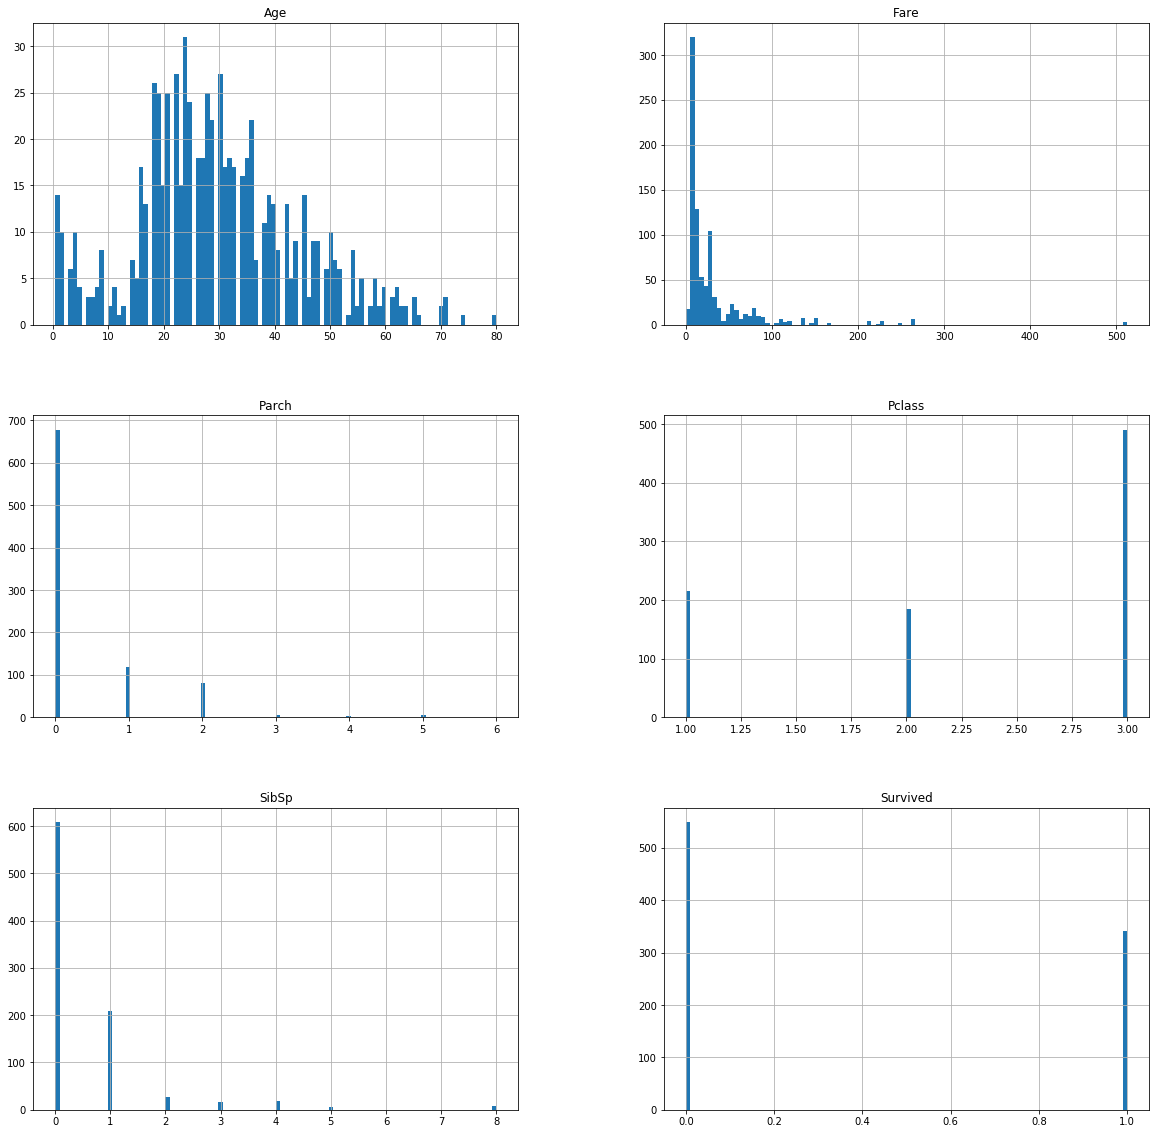

In [5]:
train_df_raw.drop(['PassengerId'], axis=1).hist(bins=100, figsize=(20,20))
plt.show()

In [67]:
def preprocess_df(df):
    data = df.copy()
    sex_dictionary = {
        'female': 0,
        'male': 1
    }
    data['Sex'] = data['Sex'].map(sex_dictionary)
    
    embarked_dictionary = {
        'C': 0,
        'Q': 1,
        'S': 2,
        pd.np.nan: 3
    }
    data['Embarked'] = data['Embarked'].map(embarked_dictionary)
    
    data['Age'].fillna(data['Age'].mean(), inplace=True)
    data['Fare'] = data['Fare'].interpolate()
    
    data['Cabin'].fillna('U', inplace=True)
    data['Cabin'] = data['Cabin'].str[:1]
    cabin_dictionary = {
        'A': 0,
        'B': 1,
        'C': 2, 
        'D': 3,
        'E': 4,
        'F': 5,
        'G': 6,
        'T': 7,
        'U': 8
    }
    data['Cabin'] = data['Cabin'].map(cabin_dictionary)
    
    data['Title'] = pd.Series(
        (name.split('.')[0].split(',')[1].strip() for name in data['Name']),
        index = data.index
    )
    title_dictionary = {
        'Capt': 0,
        'Col': 1,
        'Don': 2,
        'Dr': 3,
        'Jonkheer': 4,
        'Lady': 5,
        'Major': 6,
        'Master': 7,
        'Miss': 8,
        'Mlle': 9,
        'Mme': 10,
        'Mr': 11,
        'Mrs': 12,
        'Ms': 13,
        'Rev': 14,
        'Sir': 15,
        'the Countess': 16,
        'Dona': 17
    }
    data['Title'] = data['Title'].map(title_dictionary)
    
    data['Family_size'] = data['SibSp'] + data['Parch'] + 1
    data['isAlone'] = np.where(data['Family_size'] != 1, 0, 1)
    data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return data

In [ ]:
predictors.drop(['Survived'], axis=1, inplace=True)

In [10]:
predictors = preprocess_df(train_df_raw)

In [11]:
predictors.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family_size,isAlone
0,3,1,22.0,1,0,7.2500,8,2,11,2,0
1,1,0,38.0,1,0,71.2833,2,0,12,2,0
2,3,0,26.0,0,0,7.9250,8,2,8,1,1
3,1,0,35.0,1,0,53.1000,2,2,12,2,0
4,3,1,35.0,0,0,8.0500,8,2,11,1,1


In [12]:
target = train_df_raw['Survived']

In [13]:
target.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [24]:
sc = StandardScaler()
predictors_df = pd.DataFrame(
    sc.fit_transform(predictors.values), 
    index=predictors.index, 
    columns=predictors.columns)

X = predictors_df.as_matrix()
n_cols = X.shape[1]
y = to_categorical(target)

In [147]:
def build_ann(optimizer='adam', patience=2, n_nodes=10, n_cols=11):
    # Initializing our ANN
    model_1 = Sequential()
    
    model_1.add(Dense(
        n_nodes,  
        activation='relu', 
        input_shape=(n_cols,)))
    
    model_1.add(Dense(
        n_nodes,  
        activation='relu'))
    
    model_1.add(Dense(
        n_nodes,  
        activation='relu'))
    
    model_1.add(Dense(
        2,  
        activation='softmax'))
    
    model_1.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    
    return model_1

In [19]:
early_stopping_monitor = EarlyStopping(patience=2)

In [153]:
ann = build_ann(optimizer='adam', patience=2, n_nodes=80, n_cols=n_cols)
ann.fit(
    X, 
    y, 
#     batch_size=10, 
    epochs=100, 
    validation_split=0.2, 
    callbacks=[early_stopping_monitor]
)

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 8s 11ms/step - loss: 0.5928 - acc: 0.6938 - val_loss: 0.4548 - val_acc: 0.7709
Epoch 2/100
712/712 [==============================] - 0s 279us/step - loss: 0.4789 - acc: 0.7781 - val_loss: 0.4012 - val_acc: 0.8492
Epoch 3/100
712/712 [==============================] - 0s 326us/step - loss: 0.4534 - acc: 0.8006 - val_loss: 0.3675 - val_acc: 0.8436
Epoch 4/100
712/712 [==============================] - 0s 327us/step - loss: 0.4299 - acc: 0.8076 - val_loss: 0.3533 - val_acc: 0.8547
Epoch 5/100
712/712 [==============================] - 0s 327us/step - loss: 0.4174 - acc: 0.8216 - val_loss: 0.3447 - val_acc: 0.8603
Epoch 6/100
712/712 [==============================] - 0s 303us/step - loss: 0.4091 - acc: 0.8258 - val_loss: 0.3409 - val_acc: 0.8603
Epoch 7/100
712/712 [==============================] - 0s 313us/step - loss: 0.4047 - acc: 0.8258 - val_loss: 0.3355 - val_acc: 0.8771
Epoch 8/10

In [64]:
test_df_raw = pd.read_csv(path_test)

In [68]:
test_predictors = preprocess_df(test_df_raw)

In [69]:
sc = StandardScaler()
test_predictors_df = pd.DataFrame(
    sc.fit_transform(test_predictors.values), 
    index=test_predictors.index, 
    columns=test_predictors.columns)

X_test_predictors = test_predictors_df.as_matrix()

In [154]:
predictions = ann.predict(X_test_predictors)
predictions = predictions[:, 1]
ann_prediction = predictions > 0.6
ann_prediction = ann_prediction.astype(int)
ann_prediction

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [155]:
predicted_prob_pd = pd.DataFrame({'Survived':ann_prediction})
test_df_raw['Survived'] = predicted_prob_pd['Survived']
test_df_raw[['PassengerId', 'Survived']].to_csv('submit.csv',index=False)